# Parameter estimation

In [142]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.set_printoptions(edgeitems=2)

In [143]:
t_c = torch.tensor([0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0])
t_u = torch.tensor([35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4])
t_c, t_u

(tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000,
         -4.0000,  6.0000, 13.0000, 21.0000]),
 tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
         21.8000, 48.4000, 60.4000, 68.4000]))

- `t_c`: 因变量
- `t_u`: 自变量

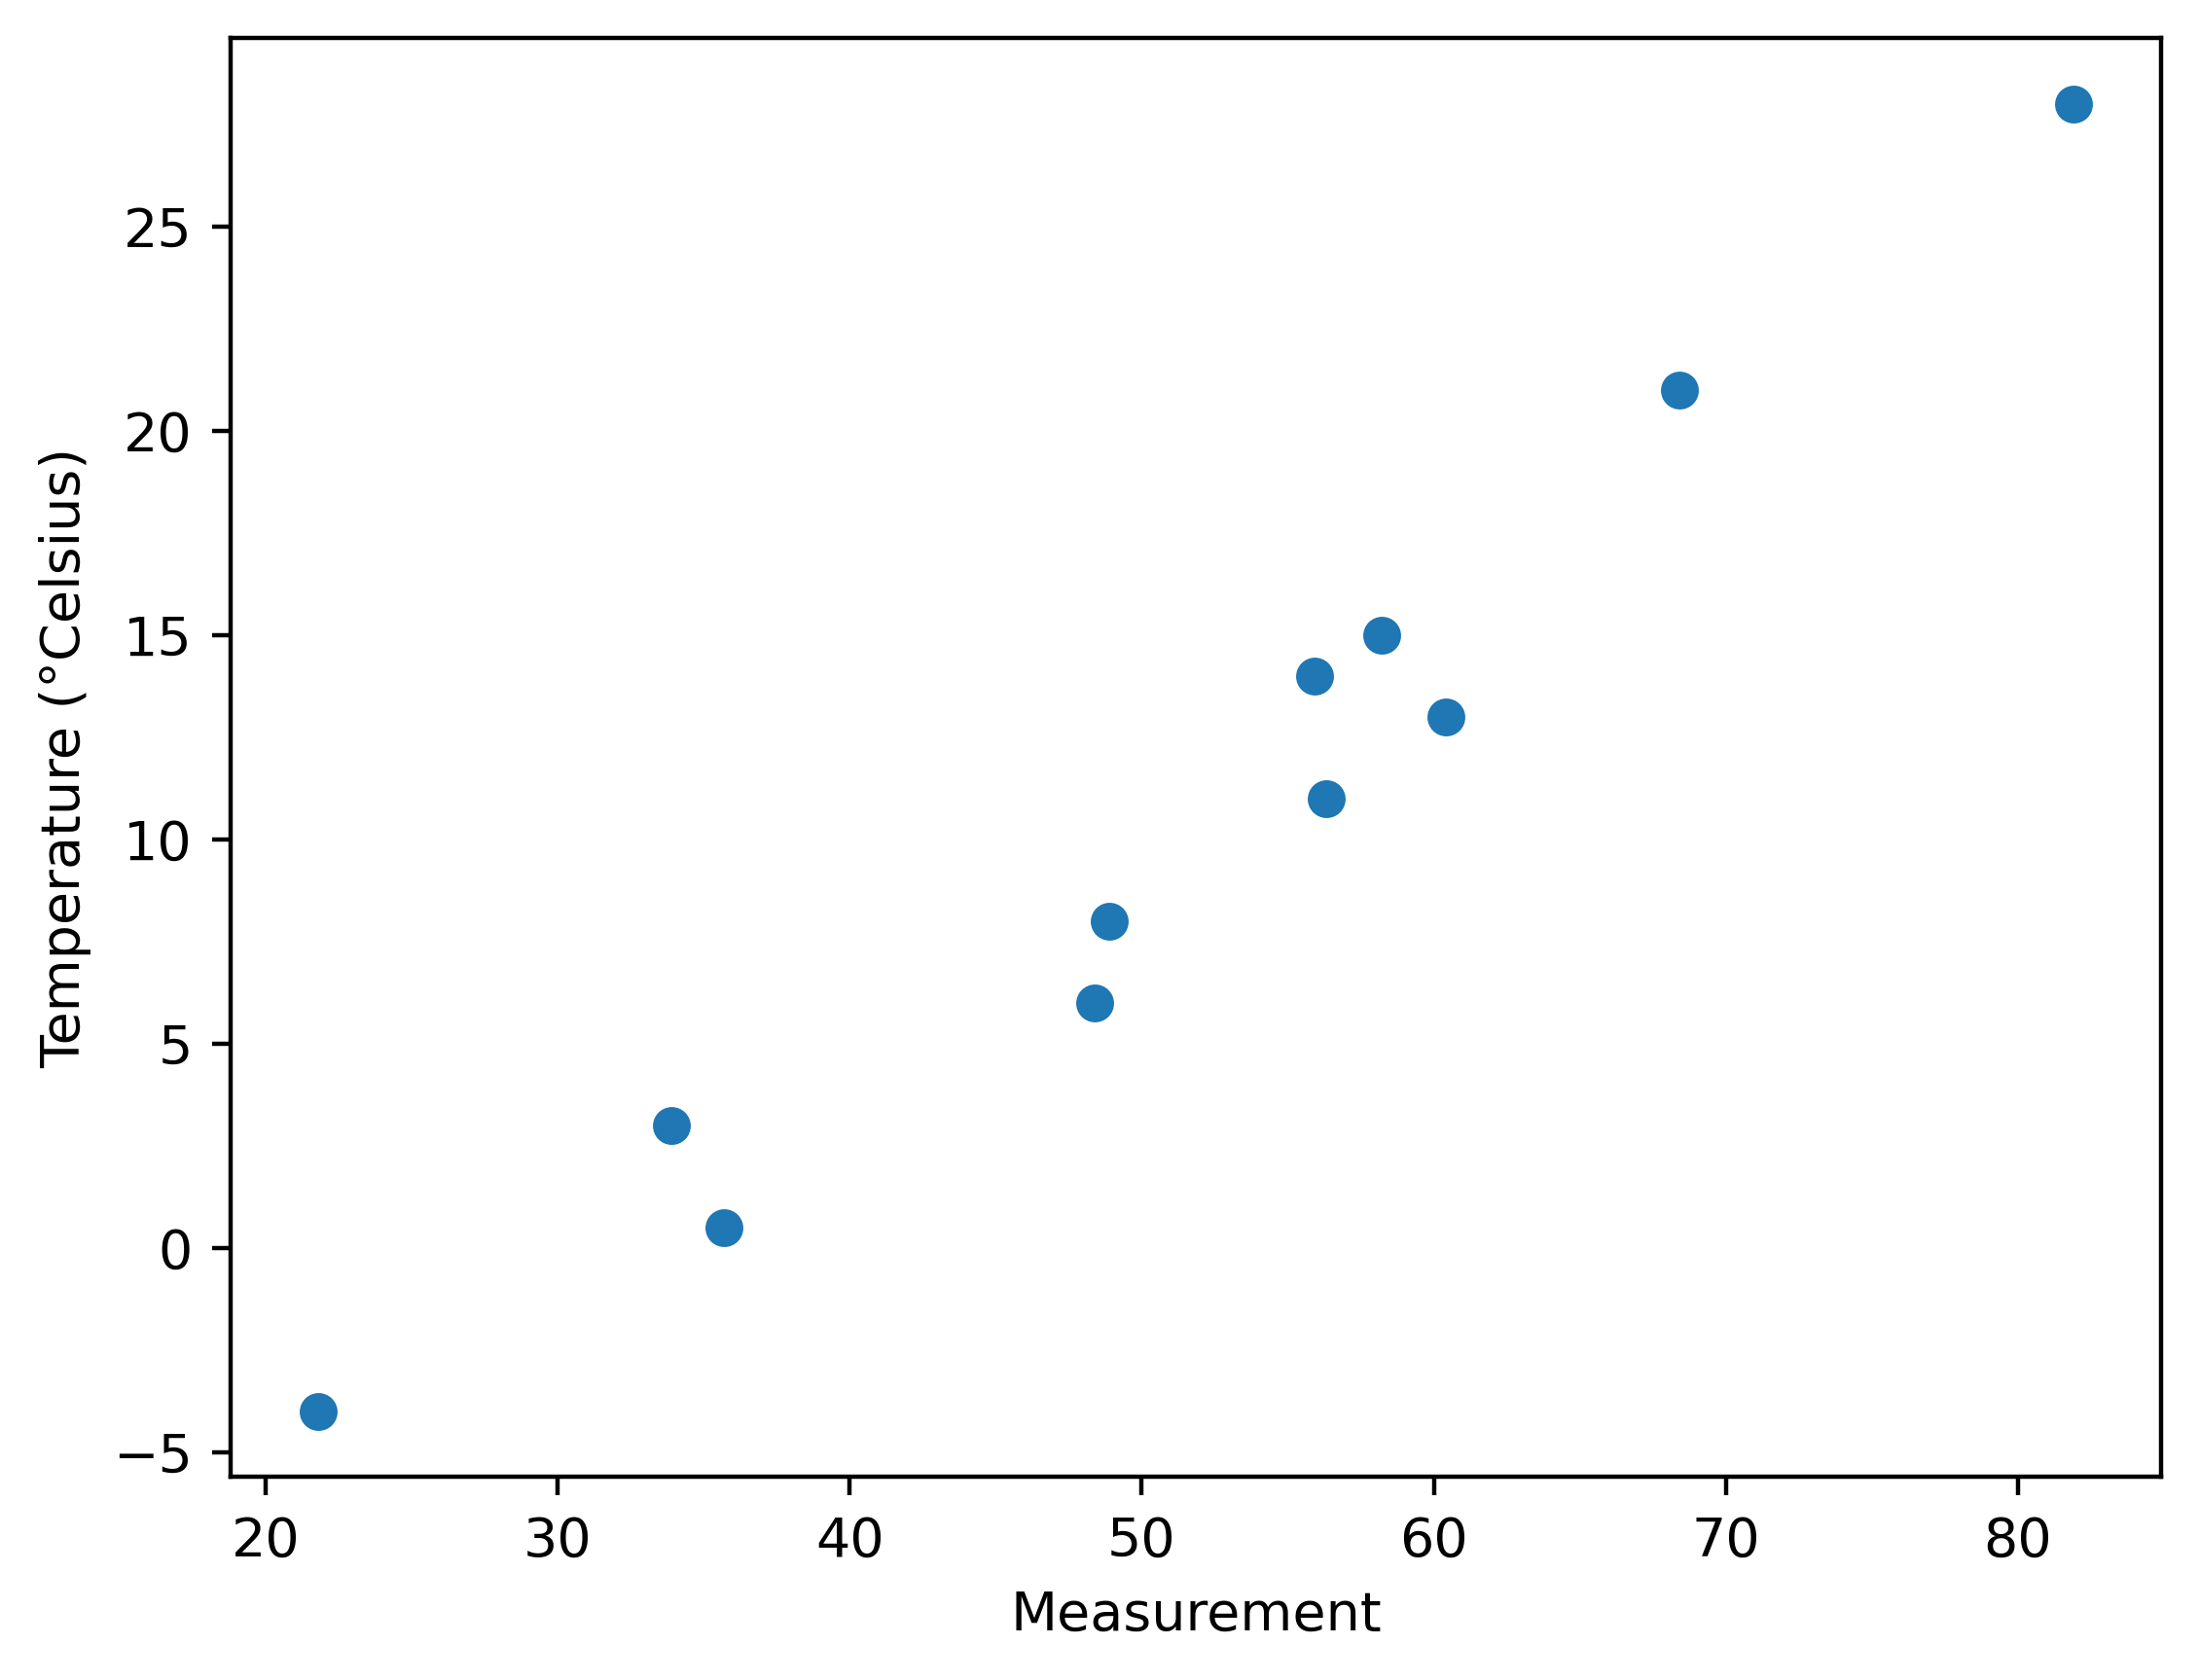

In [144]:
fig = plt.figure(dpi=400)
plt.xlabel("Measurement")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_data_plot.png", format="png")
# plt.show()

## 线性回归

在这个情况中为:

```zsh
t_c = w * t_u + b
      ↑
   (weight)
```

In [145]:
def model(t_u, w, b):
    return w * t_u + b

In [146]:
# 欧氏空间距离
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

$$
\text{loss} = \frac{1}{n} \sum_{i=1}^{n} (t_{p_i} - t_{c_i})^2
$$

In [147]:
# 初始化 w 和 b
w = torch.ones(())
b = torch.zeros(())
w, b

(tensor(1.), tensor(0.))

In [148]:
# 计算模型输出
t_p = model(t_u, w, b)
t_p, t_c

(tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
         21.8000, 48.4000, 60.4000, 68.4000]),
 tensor([ 0.5000, 14.0000, 15.0000, 28.0000, 11.0000,  8.0000,  3.0000,
         -4.0000,  6.0000, 13.0000, 21.0000]))

In [149]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

In [150]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) -
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

loss_rate_of_change_w

tensor(4517.2974)

In [151]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [152]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

loss_rate_of_change_b

tensor(-4600.)

In [153]:
b = b - learning_rate * loss_rate_of_change_b

In [154]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)
    return dsq_diffs

In [155]:
t_p.size(0) == t_c.size(0), t_p.size(0)

(True, 11)

In [156]:
def dmodel_dw(t_u, w, b):
    return t_u
def dmodel_db(t_u, w, b):
    return 1.0

In [157]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])

In [158]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

In [ ]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:  # <1>
            params.grad.zero_()
        
        t_p = model(t_u, *params) 
        loss = loss_fn(t_p, t_c)
        loss.backward()
        
        with torch.no_grad():  # <2>
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            
    return params

In [159]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3>
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

In [160]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

### 归一化输入

In [161]:
t_un = 0.1 * t_u

training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un,
    t_c = t_c)

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

### 训练5000次

In [162]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

# params

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...
Epoch 4000, Loss 2.927680
Epoch 5000, Loss 2.927648


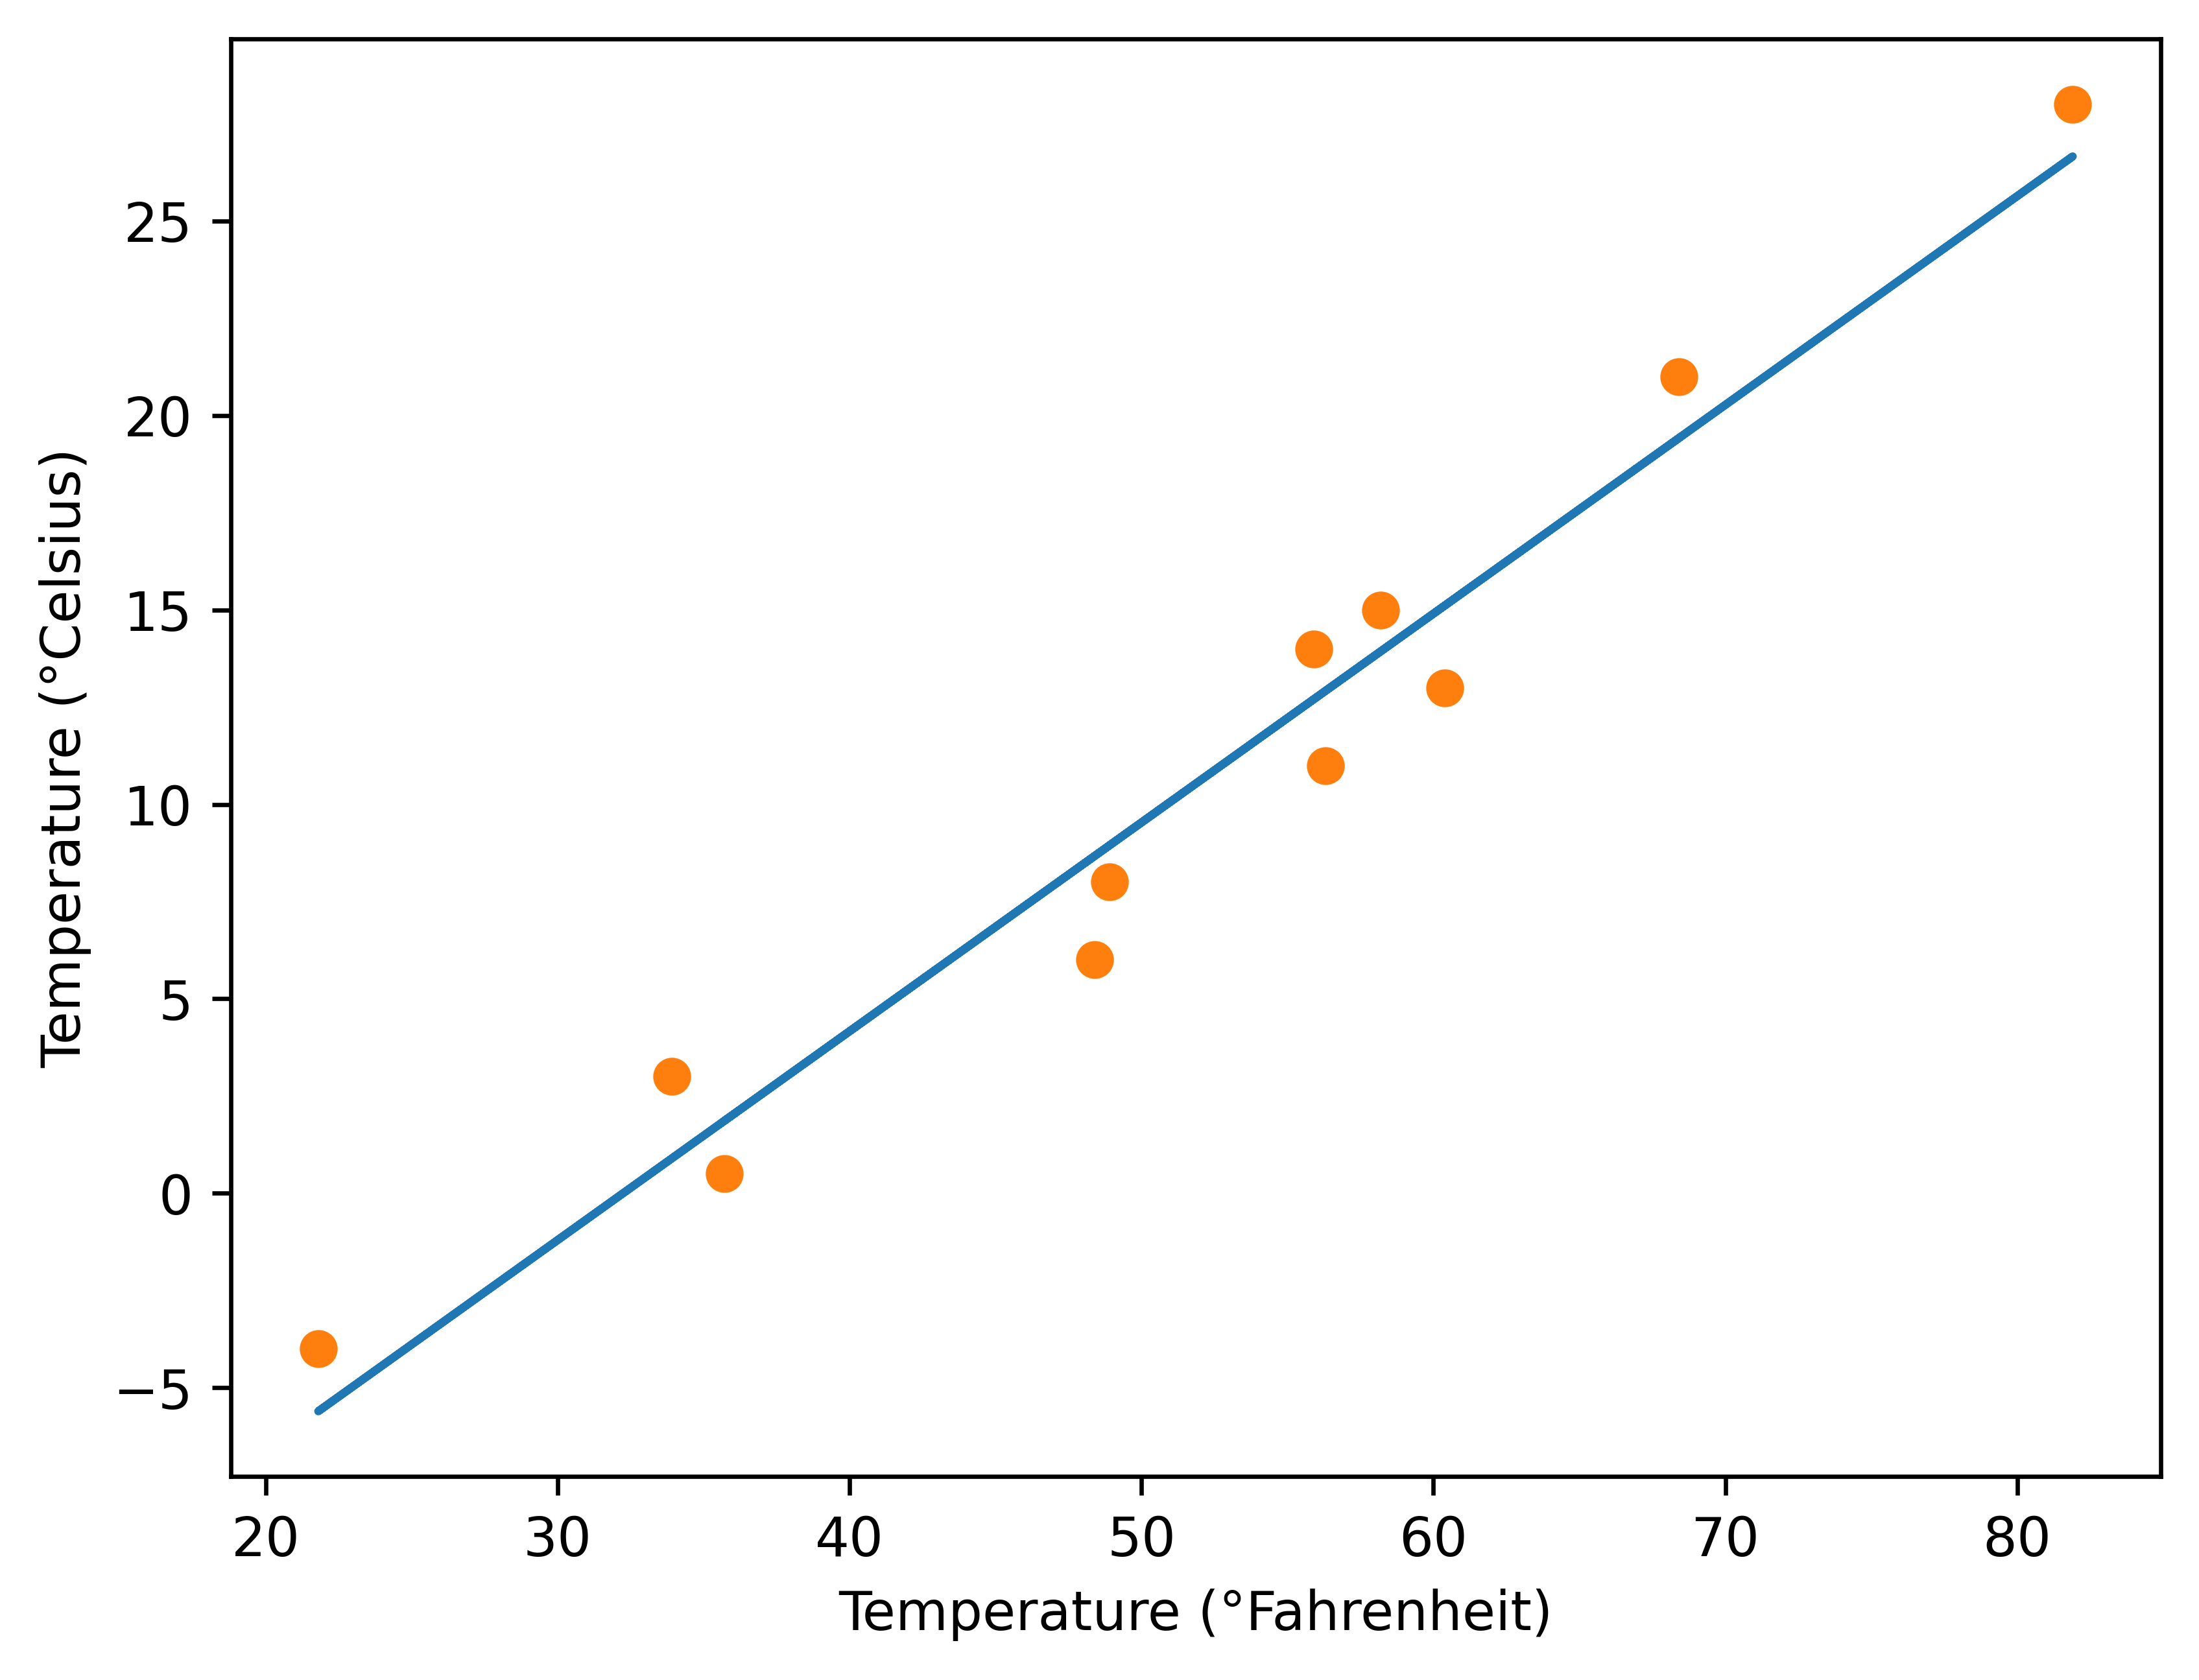

In [163]:
t_p = model(t_un, *params)

fig = plt.figure(dpi=600)
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy())
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.savefig("temp_unknown_plot.png", format="png")